In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [3]:
def param_sweep_analytic_Vm_2d(params, param_name_1, param_values_1, param_name_2, param_values_2, f0=1000.0):
    """
    Sweeps one parameter and calculates Transfer function at fixed frequency.

    Args:
        params (dict): Biophysical parameters (same as before).
        param_name (str): Name of the parameter to vary (e.g. 'l1', 'l2', 'ds').
        param_values (np.ndarray): Array of values to sweep over.
        f0 (float): Frequency (Hz) at which to evaluate the transfer function.

    Returns:
        dict: A dictionary containing:
            - param_values (np.ndarray): The swept parameter values.
            - V_m (np.ndarray): Analytical Vm at f0 for each param value.
    """
    # Angular frequency
    omega = 2 * np.pi * f0
    if omega == 0:
        omega += 1e-9

    shape = (len(param_values_1), len(param_values_2))
    results = {
        "param_values_1": param_values_1,
        "param_values_2": param_values_1,
        "V_m": np.zeros(shape, dtype=np.float64)
    }

    for i, val1 in enumerate(param_values_1):
        for j, val2 in enumerate(param_values_2):
            # Copy params and replace the swept parameter
            p = params.copy()
            p[param_name_1] = val1
            p[param_name_2] = val2

            # --- Extract parameters ---
            Rm, Ri, Cm = p['Rm'], p['Ri'], p['Cm']
            d, ds, l1, l2, s_in = p['d'], p['ds'], p['l1'], p['l2'], p['s_in']

            # --- Derived properties ---
            tau_m = Rm * Cm
            lambda_ = np.sqrt((d * Rm) / (4 * Ri))
            L1, L2 = l1 / lambda_, l2 / lambda_
            W = omega * tau_m
            q = np.sqrt(1 + 1j * W)

            # Soma admittance
            Ys = np.pi * ds**2 * (1/Rm) * q**2

            # Infinite-stick admittance
            G_inf = np.pi * d**2 / (4 * Ri * lambda_)
            Y_inf = q * G_inf

            # Total admittance
            Y_in_total = Ys + Y_inf * (np.tanh(q * L1) + np.tanh(q * L2))

            # Transfer function numerator/denominator
            numerator = lambda_ * G_inf * (1/np.cosh(q * L2) - 1/np.cosh(q * L1))
            denominator = Y_in_total

            T_p = numerator / denominator

            V_m = 1e3*np.abs(T_p)

            # Store
            results["V_m"][i,j] = V_m

    return results


In [4]:
standard_neuron_parameters = {
    'Rm': 3.0,          # Ohm * m^2
    'Ri': 1.5,          # Ohm * m
    'Cm': 0.01,         # F / m^2
    'd': 2e-6,          # 2 µm -> m
    'ds': 20e-6,        # 20 µm -> m
    'l1': 670e-6,       # 670 µm -> m (Longer stick)
    'l2': 330e-6,       # 330 µm -> m (Shorter stick)
    's_in': (1e-15)**2  # 1 fA^2/Hz -> A^2/Hz
}

neuron_parameters = standard_neuron_parameters.copy()
l1_values = np.linspace(50e-6, 1000e-6, 100)
l2_values = np.linspace(50e-6, 1000e-6, 100)
frequencies_to_plot = [10, 1000]

In [9]:
def plot_len_heatmaps(params, param_name_1, param_values_1, param_name_2, param_values_2, freqs):

    fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=False)

    # --- Plot 1: f = 10 Hz ---
    f0_1 = frequencies_to_plot[0]
    results_1 = param_sweep_analytic_Vm_2d(
        params, param_name_1, param_values_1, param_name_2, param_values_2, f0=f0_1
    )

    im1 = axes[0].imshow(
        results_1["V_m"].T,
        extent=[l1_values[0]*1e6, l1_values[-1]*1e6, l2_values[0]*1e6, l2_values[-1]*1e6],
        aspect="auto",
        origin="lower",
        cmap="viridis"
    )

    # Custom colorbar for ax1
    cbar1 = fig.colorbar(im1, ax=axes[0])
    cbar1.ax.set_ylabel("$|\hat{\mathbf{V}}_\mathrm{m}|$ Analytical [mV]")
    fmt1 = ticker.ScalarFormatter(useMathText=True)
    fmt1.set_powerlimits((-2, 2))   # switch to scientific notation if outside [1e-2, 1e2]
    fmt1.set_useOffset(False)
    cbar1.ax.yaxis.set_major_formatter(fmt1)

    offset_text1 = cbar1.ax.yaxis.get_offset_text()
    offset_text1.set_x(2.5)

    axes[0].set_xlabel("Dendrite length $l_1$ (µm)")
    axes[0].set_ylabel("Dendrite length $l_2$ (µm)") 
    axes[0].set_title(f"{f0_1} Hz", fontsize = 10)

    axes[0].scatter(787, 255, color="red", s=8)   # Pyramidal
    axes[0].scatter(220, 280, color="red", s=8)   # Inhibitory
    axes[0].text(787 - 50, 255 - 80, "Pyramidal \n average", color="red", fontsize=8, va='center')
    axes[0].text(220 - 50, 280 + 50, "Inhibitory average", color="red", fontsize=8, va='center')

    # --- Plot 2: f = 1000 Hz ---
    f0_2 = frequencies_to_plot[1]
    results_2 = param_sweep_analytic_Vm_2d(
        params, param_name_1, param_values_1, param_name_2, param_values_2, f0=f0_2
    )

    im2 = axes[1].imshow(
        results_2["V_m"].T,
        extent=[l1_values[0]*1e6, l1_values[-1]*1e6, l2_values[0]*1e6, l2_values[-1]*1e6],
        aspect="auto",
        origin="lower",
        cmap="viridis"
    )

    # Keep existing colorbar for ax2, but ensure same formatting
    cbar2 = fig.colorbar(im2, ax=axes[1])
    cbar2.ax.set_ylabel("$|\hat{\mathbf{V}}_\mathrm{m}|$ Analytical [mV]")
    fmt2 = ticker.ScalarFormatter(useMathText=True)
    fmt2.set_powerlimits((-2, 2))
    fmt2.set_useOffset(False)
    cbar2.ax.yaxis.set_major_formatter(fmt2)

    offset_text2 = cbar2.ax.yaxis.get_offset_text()
    offset_text2.set_x(2.5)

    axes[1].set_xlabel("Dendrite length $l_1$ [µm]")
    axes[1].set_ylabel("Dendrite length $l_2$ [µm]") 
    axes[1].set_title(f"{f0_2} Hz", fontsize = 10)

    axes[1].scatter(787, 255, color="red", s=8)
    axes[1].scatter(220, 280, color="red", s=8)
    axes[1].text(787 - 50, 255 - 80, "Pyramidal \n average", color="red", fontsize=8, va='center')
    axes[1].text(220 - 50, 280 + 50, "Inhibitory average", color="red", fontsize=8, va='center')

    axes[0].text(-0.3, 1.10, 'A', transform=axes[0].transAxes, fontsize=12, fontweight='bold')
    axes[1].text(-0.3, 1.10, 'B', transform=axes[1].transAxes, fontsize=12, fontweight='bold')

    # fig.suptitle('Transfer function $|T_p^s|$')

    plt.tight_layout()
    plt.savefig('/Users/susannedahle/Documents/Master/Code/fig_pdfs/transfer/fig9.pdf')
    plt.show()

<>:21: SyntaxWarning: invalid escape sequence '\h'
<>:55: SyntaxWarning: invalid escape sequence '\h'
<>:21: SyntaxWarning: invalid escape sequence '\h'
<>:55: SyntaxWarning: invalid escape sequence '\h'
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_60872/818336297.py:21: SyntaxWarning: invalid escape sequence '\h'
  cbar1.ax.set_ylabel("$|\hat{\mathbf{V}}_\mathrm{m}|$ Analytical [mV]")
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_60872/818336297.py:55: SyntaxWarning: invalid escape sequence '\h'
  cbar2.ax.set_ylabel("$|\hat{\mathbf{V}}_\mathrm{m}|$ Analytical [mV]")


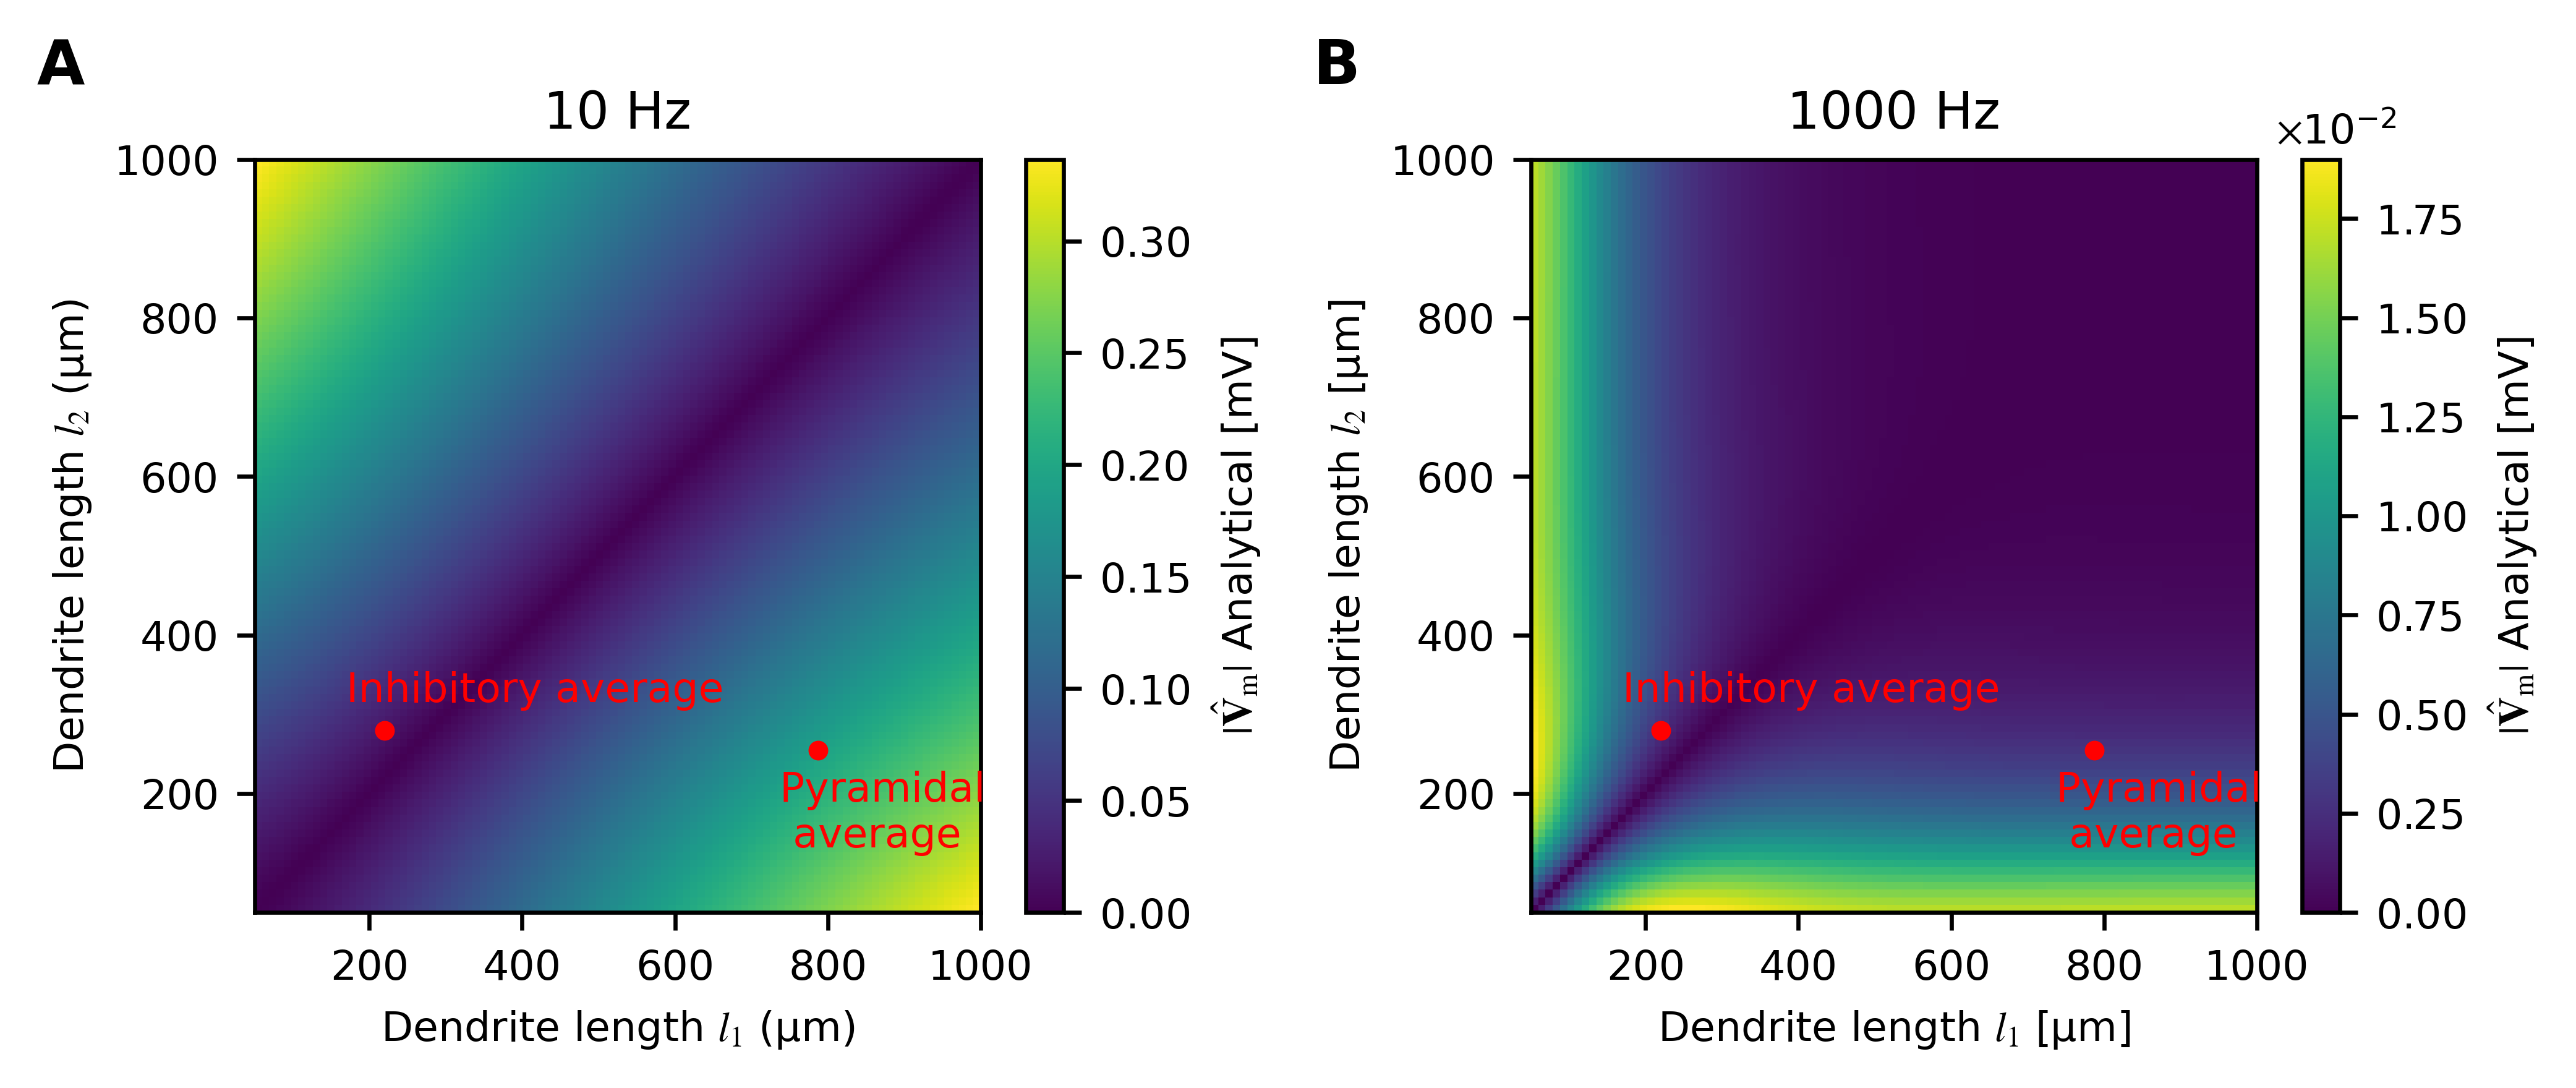

In [10]:
plot_len_heatmaps(
    params=neuron_parameters, 
    param_name_1='l1', param_values_1=l1_values,
    param_name_2='l2', param_values_2=l2_values, 
    freqs=frequencies_to_plot
)